# Text Summarizer Webinar

___ 


**Tutor**: *Dr Koh Noi Sian*

**By**: *Zhang Xiang*

**Course**: *DAAA*

**Admin No**: 210896X

___

### Background
The objective of this project is to develop a transcription and text summarizer that can be used to generate summaries for multi-speaker videos. As most of the webinars and panel discussion videos are at least an hour, users may prefer to read through a summary on the key topics and key threads discussed before deciding to invest their time in viewing the entire video. The summary could also provide the gist of the discussion and help the users to recap and reinforce their learning after viewing the video. We will be evaluating the current state-of-the-art tools in text transcription and leverage on the service that provides the best accuracy in transcribing webinars with speakers from Southeast Asian accent. Finally, we will be using OpenAI to customise the model for the text summarizer.

___


### Consideration

It was found out that TIB dataset is more suitable for our use case, I will use TIB dataset throughout for testing.

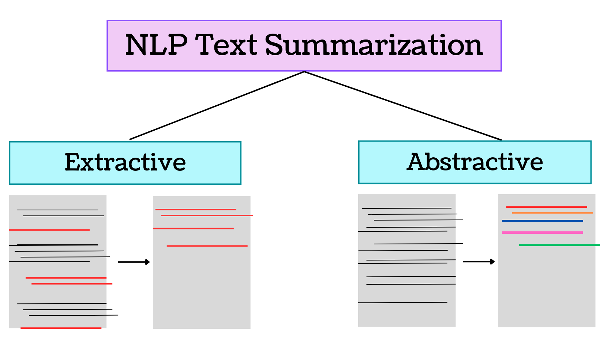


Using LLMs for Summarization means using **Abstractive Summarization** instead of Extractive Summarization.

| **Type** | **Extractive Summarization** | **Abstractive Summarization** |
|---|---|---|
| **Definition** | Selects key sentences, phrases, or words from the original text and combines them to create a summary. | Generates new sentences to represent the most important information from the original text. |
| **Advantages** | 1. Easier to implement.<br>2. Maintains the accuracy of information as it directly picks the sentences from the source. | 1. Generates more human-like text.<br>2. Can handle implicit information and make inferences.<br>3. More flexible and can generate a summary that is not constrained by the original text. |
| **Disadvantages** | 1. Can lead to disjointed sentences.<br>2. May not capture the overall semantic meaning.<br>3. Cannot handle implicit information. | 1. More complex to implement.<br>2. Risk of generating inaccurate or misleading information. |


Reasons to choose **Abstractive Summarization** over Extractive Summarization:

- **Human-like Text**: Abstractive summarization generates more human-like summaries, which can be easier to read and understand.
- **Handling Implicit Information**: It can handle indirect information and make inferences, which extractive summarization cannot.
- **Flexibility**: It is more flexible and can generate a summary that is not constrained by the original text.


### Steps:

1. **Install & Import Necessary Libraries**
2. **Helper Function**
3. **Load Dataset**
4. **MapReduce Summarizer**

    - 512 Tokens Model
    - 1024 Tokens Model
    - More than 1024 Tokens Modle

5. **Eliminate Model**

    - Eliminate Model with Long Runtime
    - Find Top 8 Models with Highest BERT Score
    - Find Top 5 Models with Best Rouge Score

6. **TextRank Summarizer**
    - Test Top 5 Models with best performance in MapReduce
    - Test it with 10, 50 and 100 Sentences.

### Install & Import Necessary Libraries

In [2]:
# !pip install torch torchtext datasets tiktoken sentence_transformers
# !pip install py-readability-metrics rouge rouge_score nltk absl-py bert-score language_tool_python
# !python -m nltk.downloader punkt

In [1]:
import time
import sys
sys.path.append('../')
from helper.SummarizationMetrics import SummarizationMetrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import ast
import seaborn as sns


import torch
import transformers
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from  langchain import LLMChain, HuggingFacePipeline, PromptTemplate
from langchain.chains.summarize import load_summarize_chain
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter

from sentence_transformers import SentenceTransformer, util
from scipy.signal import argrelextrema
from sklearn.cluster import KMeans


import nltk
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('punkt')
nltk.download('stopwords')

c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>
[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

### Modelling

##### Metrics
| Metric      | Description                                                                                                      | Strengths                                                                                       | Weaknesses                                                                                                      |
|-------------|------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------|
| ROUGE       | Measures overlap of n-grams (unigrams, bigrams) between generated and reference summaries.              | - Captures content similarity effectively.                                                      | - Ignores word order and semantics. <br> - Do not capture the overall quality of text.                               |
| BLEU (Not Using)        | Evaluates precision of n-grams in the generated summary compared to the reference summary. Usually for translation purpose.                      | - Simple and easy to compute. <br> - Widely used in machine translation and summarization.          | - Does not capture overall meaning or fluency, may penalize longer summaries       |
| BERT Score  | Utilizes pre-trained BERT embeddings to measure the similarity between the generated and reference summaries. | - Considers contextual information. <br>- Effective for capturing semantic similarity.               | - Computationally expensive. <br>- Requires pre-trained BERT model. <br>- May not be suitable for all summarization tasks. |
| Readability Metrics | Measures the ease of understanding the generated summary.                                        | - Provides insights into summary readability. <br> - Useful for applications with specific readability requirements. | - May not measure text information or content relevance.                                                    |
| Grammar Measurement| Identify and count grammar errors in a given text.  | - Provides detailed error feedback.    | - Dependent on external library. <br> - Does not capture semantic errors. |

For ROUGE, I will use F-score to identify good model as it indicates that the model achieves a good balance between recall and precision, providing both informative and accurate text.


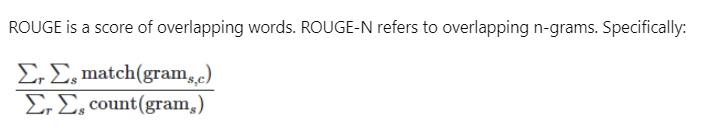
https://stackoverflow.com/questions/9879276/how-do-i-evaluate-a-text-summarization-tool


##### Additional Metrics:

| Feature | Description |
|---|---|
| Domain | The domain of the text being summarized. For example, a model trained on news articles may not perform well on scientific papers. |
| Length | The desired length of the summary. Some models may be better at generating short summaries, while others may be better at generating longer summaries. |
| Speed | The time it takes to generate a summary. This may be important if the summarizer is being used in a real-time application. |


##### Text - Preprocessing Method

The transcripts come from long videos, usually over an hour. These transcripts have a lot of words, and many models find it hard to work with so many words. So, the MapReduce method and splitting text into chunk to make process faster and easier.

**RecursiveCharacterTextSplitter**: Break down a large text document into smaller chunks suitable for processing by a pre-trained transformer.

**Map-Reduce**: Summarize each document on it’s own in a “map” step and then “reduce” the summaries into a final summary. 



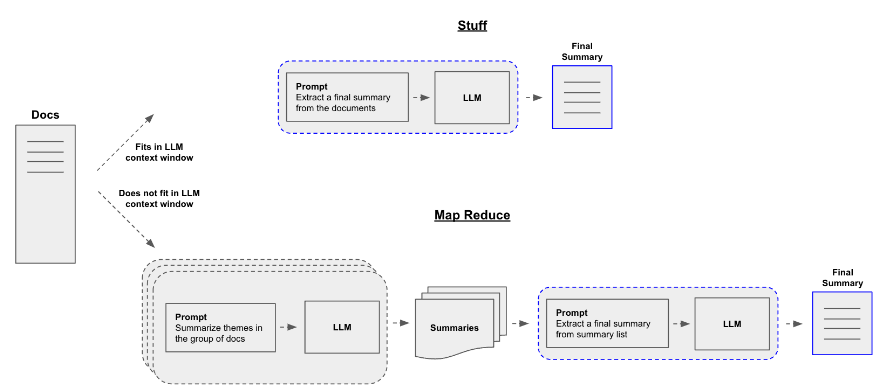


**Model Tokens Choices**

1 token ~= 3/4 words

| Token Limit | Pros | Cons |
|-------------|------|------|
| 512         | Faster, more efficient, good for short texts | Limited context for long texts, requires additional handling for long texts |
| 1024 / More        | Can process longer texts, might result in better understanding and summarization of the text, less additional handling needed | Less efficient, potential of excess processing for short texts |


Since out text is consistently exceeding 1024 tokens, I will decide to use a larger model, with implementation of text chunking and summarize it in multiple stages until it reach the final target summary size.





#### Helper Function

In [2]:
def summ_pipeline(model, tokenizer, chain_type, max_length, prompt=False):
  pipeline = transformers.pipeline(
      "summarization",
      model=model,
      tokenizer=tokenizer,
      torch_dtype=torch.bfloat16,
      trust_remote_code=True,
      device_map="auto",
      max_length=max_length,
      do_sample=True,
      top_k=10,
      num_return_sequences=1,
      eos_token_id=tokenizer.eos_token_id,
  )
  llm = HuggingFacePipeline(pipeline = pipeline)

  if chain_type == "map_reduce":
    if prompt:
      prompt_template = """Summarize this: ```{text}```"""
      prompt_message = PromptTemplate(template=prompt_template, input_variables=["text"])
      
      summary_chain = load_summarize_chain(llm=llm, chain_type=chain_type, token_max=max_length, prompt=prompt_message)
    else:
      summary_chain = load_summarize_chain(llm=llm, chain_type=chain_type, token_max=max_length)
  else:
    # can't get it to work with refine and stuff, think they updated the library but no documentation
    # on how to set token_max
    summary_chain = load_summarize_chain(llm=llm, chain_type=chain_type)
  return summary_chain

In [3]:
# Order sentence by length and get top important/longest sentences
def text_rank_summary(text, num_sentences=20):
    # Tokenize sentences and words
    sentences = sent_tokenize(text)
    words = [word_tokenize(sentence) for sentence in sentences]

    # Remove stopwords and punctuation, and lowercase the words
    stop_words = set(stopwords.words('english'))
    filtered_words = [[word.lower() for word in words if word.isalnum() and word.lower() not in stop_words] for words in words]

    # Calculate word frequency
    word_freq = FreqDist([word for sentence in filtered_words for word in sentence])

    # Calculate sentence scores based on word frequency
    sentence_scores = {}
    for i, sentence in enumerate(filtered_words):
        sentence_scores[i] = sum([word_freq[word] for word in sentence])

    # Sort sentences by score in descending order
    sorted_sentences = sorted(sentence_scores, key=sentence_scores.get, reverse=True)

    # Generate the summary
    selected_sentences = [sentences[i] for i in sorted_sentences[:num_sentences]]
    final_summary = ' '.join(selected_sentences)

    return final_summary

In [4]:
def getParagraphs(model, sentences):
    # Embed sentences
    embeddings = model.encode(sentences)

    # Create similarities matrix
    similarities = util.pytorch_cos_sim(embeddings, embeddings).numpy()

    def rev_sigmoid(x: float) -> float:
        return 1 / (1 + math.exp(0.5 * x))

    def activate_similarities(similarities: np.array, p_size=10) -> np.array:
        # To create weights for sigmoid function, we first create a space.
        x = np.linspace(-10, 10, p_size)
        y = np.vectorize(rev_sigmoid)  # Apply activation function
        activation_weights = np.pad(y(x), (0, similarities.shape[0] - p_size))

        diagonals = [similarities.diagonal(each) for each in range(0, similarities.shape[0])]
        diagonals = [np.pad(each, (0, similarities.shape[0] - len(each))) for each in diagonals]
        diagonals = np.stack(diagonals)
        diagonals = diagonals * activation_weights.reshape(-1, 1)
        activated_similarities = np.sum(diagonals, axis=0)
        return activated_similarities

    activated_similarities = activate_similarities(similarities, p_size=10)

    minmimas = argrelextrema(activated_similarities, np.less, order=2)

    split_points = [each for each in minmimas[0]]
    paragraphs = []
    paragraph = ''
    for num, each in enumerate(sentences):
        paragraph += each
        if num in split_points:
            paragraphs.append(paragraph)
            paragraph = ''

    return paragraphs

def getImportantParagraphs(vectors, paragraphs, num_clusters=11):
    # need to split before embed docs then kmeans to see which one doesn't need to be summarized etc.
    # bcs we dh predefined pages or paragraphs it makes it abit more complicated
    # aft picking the most impt runs, do map reduce on those to see if it gets a better summary
    num_clusters = 11

    # Perform K-means clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(vectors)

    # Find the closest embeddings to the centroids

    # Create an empty list that will hold your closest points
    closest_indices = []

    # Loop through the number of clusters you have
    for i in range(num_clusters):

        # Get the list of distances from that particular cluster center
        distances = np.linalg.norm(vectors - kmeans.cluster_centers_[i], axis=1)

        # Find the list position of the closest one (using argmin to find the smallest distance)
        closest_index = np.argmin(distances)

        # Append that position to your closest indices list
        closest_indices.append(closest_index)

    selected_indices = sorted(closest_indices)
    return [paragraphs[doc] for doc in selected_indices]

### TIB DATASET
#### Loading Data

For Model Evaluation with comparison of original summary and generated summary.

In [6]:
df = pd.read_excel("../data/tib_test.xlsx")

df_test = df.head(5)

df_test

,summary,transcript
0,A firsthand look at efforts to improve diversi...,All right. So our next talk is called Hacking...
1,It is certainly a time of discovery- though th...,"Welcome, DEF CON 28, the Do No Harm panel. Th..."
2,Roman Architecture (HSAR 252) Professor Kleine...,Good morning. As you can see from the title o...
3,Stochastic rewriting systems evolving over gra...,"Thank you very much, first important question..."
4,"In typical military operations, the advantage ...",I was great to be with all of you today. I sa...


### Open Source Summarizer

**Hugging Face Summarizer Model**

| Model                         | Description                                                                         | Max Tokens |
|-------------------------------|-------------------------------------------------------------------------------------|------------|
| google/pegasus-xsum | Pegasus' pretraining task is intentionally similar to summarization. Sequence-to-sequence model with the same encoder-decoder model architecture as BART. Pegasus is pre-trained jointly on two self-supervised objective functions: Masked Language Modeling (MLM) and a novel summarization specific pretraining objective, called Gap Sentence Generation (GSG). | 512  |

<br>

| Model                         | Description                                                                         | Max Tokens |
|-------------------------------|-------------------------------------------------------------------------------------|------------|
| facebook/bart-large-cnn      | BART model pre-trained on English language and fine-tuned on CNN Daily Mail. BART is a transformer encoder-decoder (seq2seq) model with a bidirectional (BERT-like) encoder and an autoregressive (GPT-like) decoder. | 1024  |
| sshleifer/distilbart-xsum-12-6      | Distilled version of the Bart model, which is a large language model. Distillation is a technique that reduces the size of a large language model while preserving as much of its performance as possible. It offers better performance than "distilbart-12-6-cnn". | 1024  |
| philschmid/bart-large-cnn-samsum    | Trained using Amazon SageMaker and the new Hugging Face Deep Learning container.                                                                    | 1024 |
| philschmid/flan-t5-base-samsum      | A fine-tuned version of "google/flan-t5-base" on the samsum dataset.                                                                                | 1024 |

<br>

| Model                         | Description                                                                         | Max Tokens |
|-------------------------------|-------------------------------------------------------------------------------------|------------|
| HHousen/distil-led-large-cnn-16384  | This model can process 16K tokens by copying "sshleifer/distilbart-cnn-12-6's" position embedding matrix 16 times.                                | 16384 |




In [7]:
# List of models
models_512 = [
    "google/pegasus-xsum",
    "mrm8488/flan-t5-large-finetuned-openai-summarize_from_feedback"
]

models_1024 = [
    "facebook/bart-large-cnn",
    # "google/pegasus-cnn_dailymail",
    "sshleifer/distilbart-xsum-12-6",
    "facebook/bart-large-xsum",
    "philschmid/bart-large-cnn-samsum",
    # "philschmid/flan"
]

# Models with more tokens
models_other = [
    "HHousen/distil-led-large-cnn-16384",
    "pszemraj/long-t5-tglobal-base-16384-book-summary",
    # "hyesunyun/update-summarization-bart-large-longformer",
    "pszemraj/led-large-book-summary",
    # "google/bigbird-pegasus-large-arxiv",
    "pszemraj/led-base-book-summary",
    # "ArtifactAI/led_large_16384_arxiv_summarization",
]

df_models_512 = pd.DataFrame(models_512, columns=["Models"])

df_models_1024 = pd.DataFrame(models_1024, columns=["Models"])

df_models_other = pd.DataFrame(models_other, columns=["Models"])

In [7]:
# DataFrame to store metrics of model performance
df_scores = pd.DataFrame(columns=['model', 'method', 'max_tokens' ,'transcript','original summary', 'summary', 'rouge','bert_score', 'bleu', 'time_taken', 'grammar', 'readability'])

#### MapReduce Method

In [8]:
for model_name in df_models_512['Models']:
    print(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

    for index, row in df_test.iterrows():
        method = "MapReduce"
        
        # get the summary
        start_time = time.time()


        max_tokens = tokenizer.model_max_length
        summary_chain = summ_pipeline(model, tokenizer, "map_reduce", max_tokens)

        # Used for efficient tokenization and processing of long texts when working with language models
        text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=max_tokens-100, chunk_overlap=100)
        docs = text_splitter.create_documents([row["transcript"]])
        summary = summary_chain.run(docs)


        end_time = time.time()
        elapsed_time = end_time - start_time

        metrics = SummarizationMetrics(row['summary'], summary)

        new_result = {
            'model': model_name,
            'method': method,
            'max_tokens': max_tokens,
            'transcript': row['transcript'],
            'original summary': row['summary'],
            'summary': summary,
            'rouge': metrics.rouge_scores(),
            'bert_score': metrics.bert_score(),
            'bleu': metrics.bleu_score(),
            'time_taken': elapsed_time,
            'grammar': metrics.grammar_check(),
            'readability': metrics.readability_index()
        }


        new_row = pd.DataFrame([new_result])

        df_scores = pd.concat([df_scores, new_row], ignore_index=True)


google/pegasus-xsum


Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Your max_length is set to 512, but your input_length is only 433. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=216)
Your max_length is set to 512, but your input_length is only 430. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=215)
Your max_length is set to 512, but your input_length is only 425. Since this is a summarization task, where outputs shorter than the input are typically wanted, 

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.71s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 76.93it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 2.75 seconds, 0.36 sentences/sec


C:\Users\Zhang Xiang\AppData\Local\Temp\ipykernel_7032\2172776429.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_scores = pd.concat([df_scores, new_row], ignore_index=True)
Your max_length is set to 512, but your input_length is only 434. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=217)
Your max_length is set to 512, but your input_length is only 437. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=218)
Your max_length is set to 512, but your input_length is only 433. 

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 499.38it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 1.90 seconds, 0.53 sentences/sec


Your max_length is set to 512, but your input_length is only 426. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=213)
Your max_length is set to 512, but your input_length is only 426. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=213)
Your max_length is set to 512, but your input_length is only 429. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=214)
Your max_length is set to 512, but your input_length is only 420. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:03<00:00,  3.10s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 249.66it/s]


done in 3.11 seconds, 0.32 sentences/sec


Your max_length is set to 512, but your input_length is only 423. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=211)
Your max_length is set to 512, but your input_length is only 430. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=215)
Your max_length is set to 512, but your input_length is only 434. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=217)
Your max_length is set to 512, but your input_length is only 432. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.82s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 166.71it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 2.84 seconds, 0.35 sentences/sec


Your max_length is set to 512, but your input_length is only 435. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=217)
Your max_length is set to 512, but your input_length is only 437. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=218)
Your max_length is set to 512, but your input_length is only 435. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=217)
Your max_length is set to 512, but your input_length is only 443. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 83.33it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\tr

done in 2.09 seconds, 0.48 sentences/sec
mrm8488/flan-t5-large-finetuned-openai-summarize_from_feedback


Your max_length is set to 512, but your input_length is only 455. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=227)
Your max_length is set to 512, but your input_length is only 476. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=238)
Your max_length is set to 512, but your input_length is only 479. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=239)
Your max_length is set to 512, but your input_length is only 483. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.83s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 42.54it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 1.87 seconds, 0.53 sentences/sec


Your max_length is set to 512, but your input_length is only 475. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=237)
Your max_length is set to 512, but your input_length is only 476. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=238)
Your max_length is set to 512, but your input_length is only 465. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=232)
Your max_length is set to 512, but your input_length is only 458. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 333.46it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 1.44 seconds, 0.70 sentences/sec


Your max_length is set to 512, but your input_length is only 465. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=232)
Your max_length is set to 512, but your input_length is only 464. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=232)
Your max_length is set to 512, but your input_length is only 462. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=231)
Your max_length is set to 512, but your input_length is only 464. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 332.99it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\t

done in 2.52 seconds, 0.40 sentences/sec


Your max_length is set to 512, but your input_length is only 460. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=230)
Your max_length is set to 512, but your input_length is only 470. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=235)
Your max_length is set to 512, but your input_length is only 467. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=233)
Your max_length is set to 512, but your input_length is only 465. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:03<00:00,  3.10s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 249.93it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 3.11 seconds, 0.32 sentences/sec


Your max_length is set to 512, but your input_length is only 458. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=229)
Your max_length is set to 512, but your input_length is only 459. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=229)
Your max_length is set to 512, but your input_length is only 450. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=225)
Your max_length is set to 512, but your input_length is only 460. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=2

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.09s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 36.17it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 2.13 seconds, 0.47 sentences/sec


In [8]:
df_scores = pd.read_excel("./result/open_source_model.xlsx")
df_scores

,model,method,max_tokens,transcript,original summary,summary,rouge,bert_score,bleu,time_taken,grammar,readability
0,google/pegasus-xsum,MapReduce,5.120000e+02,All right. So our next talk is called Hacking...,A firsthand look at efforts to improve diversi...,What do you think about the BBC's series of le...,"[{'rouge-1': {'r': 0.03571428571428571, 'p': 0...","(tensor([0.8401]), tensor([0.7999]), tensor([0...",3.830113e-159,204.872731,[],100 words required.
1,google/pegasus-xsum,MapReduce,5.120000e+02,"Welcome, DEF CON 28, the Do No Harm panel. Th...",It is certainly a time of discovery- though th...,All letters to the editor are copyrighted.,"[{'rouge-1': {'r': 0.015748031496062992, 'p': ...","(tensor([0.8332]), tensor([0.7905]), tensor([0...",1.129354e-165,245.156380,[],100 words required.
2,google/pegasus-xsum,MapReduce,5.120000e+02,Good morning. As you can see from the title o...,Roman Architecture (HSAR 252) Professor Kleine...,In our series of letters from African journali...,"[{'rouge-1': {'r': 0.06428571428571428, 'p': 0...","(tensor([0.8357]), tensor([0.7890]), tensor([0...",5.017347e-05,252.242959,"[Match({'ruleId': 'MORFOLOGIK_RULE_EN_US', 'me...",100 words required.
3,google/pegasus-xsum,MapReduce,5.120000e+02,"Thank you very much, first important question...",Stochastic rewriting systems evolving over gra...,What do you think are the most popular letters...,"[{'rouge-1': {'r': 0.016666666666666666, 'p': ...","(tensor([0.8331]), tensor([0.7609]), tensor([0...",3.860907e-165,260.781992,[],100 words required.
4,google/pegasus-xsum,MapReduce,5.120000e+02,I was great to be with all of you today. I sa...,"In typical military operations, the advantage ...",What are the proactive ways that you can defen...,"[{'rouge-1': {'r': 0.022222222222222223, 'p': ...","(tensor([0.8531]), tensor([0.7846]), tensor([0...",6.640595e-240,209.853703,[],100 words required.
5,mrm8488/flan-t5-large-finetuned-openai-summari...,MapReduce,5.120000e+02,All right. So our next talk is called Hacking...,A firsthand look at efforts to improve diversi...,Feminist hackers are trying to create a space ...,"[{'rouge-1': {'r': 0.047619047619047616, 'p': ...","(tensor([0.8397]), tensor([0.8034]), tensor([0...",8.681553e-158,135.840664,"[Match({'ruleId': 'MORFOLOGIK_RULE_EN_US', 'me...",100 words required.
6,mrm8488/flan-t5-large-finetuned-openai-summari...,MapReduce,5.120000e+02,"Welcome, DEF CON 28, the Do No Harm panel. Th...",It is certainly a time of discovery- though th...,What are some recent developments that have ma...,"[{'rouge-1': {'r': 0.13385826771653545, 'p': 0...","(tensor([0.8234]), tensor([0.8095]), tensor([0...",4.017213e-155,162.681585,"[Match({'ruleId': 'MORFOLOGIK_RULE_EN_US', 'me...","score: 16.235828025477705, grade_level: '16'"
7,mrm8488/flan-t5-large-finetuned-openai-summari...,MapReduce,5.120000e+02,Good morning. As you can see from the title o...,Roman Architecture (HSAR 252) Professor Kleine...,What changes in architecture during the first ...,"[{'rouge-1': {'r': 0.04285714285714286, 'p': 0...","(tensor([0.8642]), tensor([0.7608]), tensor([0...",8.587572e-239,182.091449,[],100 words required.
8,mrm8488/flan-t5-large-finetuned-openai-summari...,MapReduce,5.120000e+02,"Thank you very much, first important question...",Stochastic rewriting systems evolving over gra...,How can you understand how a biological system...,"[{'rouge-1': {'r': 0.05, 'p': 0.27272727272727...","(tensor([0.8352]), tensor([0.7799]), tensor([0...",1.846347e-157,165.099411,[],100 words required.
9,mrm8488/flan-t5-large-finetuned-openai-summari...,MapReduce,5.120000e+02,I was great to be with all of you today. I sa...,"In typical military operations, the advantage ...",What is the basis for a better model to use to...,"[{'rouge-1': {'r': 0.08148148148148149, 'p': 0...","(tensor([0.8443]), tensor([0.7958]), tensor([0...",8.311254e-157,137.744869,"[Match({'ruleId': 'COMMA_COMPOUND_SENTENCE_2',...",100 words required.


In [9]:
for model_name in df_models_1024['Models']:
    print(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

    for index, row in df_test.iterrows():
        method = "MapReduce"
        
        # get the summary
        start_time = time.time()


        max_tokens = tokenizer.model_max_length
        summary_chain = summ_pipeline(model, tokenizer, "map_reduce", max_tokens)

        # Used for efficient tokenization and processing of long texts when working with language models
        text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=max_tokens-100, chunk_overlap=100)
        docs = text_splitter.create_documents([row["transcript"]])
        summary = summary_chain.run(docs)


        end_time = time.time()
        elapsed_time = end_time - start_time
        
        metrics = SummarizationMetrics(row['summary'], summary)

        new_result = {
            'model': model_name,
            'method': method,
            'max_tokens': max_tokens,
            'transcript': row['transcript'],
            'original summary': row['summary'],
            'summary': summary,
            'rouge': metrics.rouge_scores(),
            'bert_score': metrics.bert_score(),
            'bleu': metrics.bleu_score(),
            'time_taken': elapsed_time,
            'grammar': metrics.grammar_check(),
            'readability': metrics.readability_index()
        }


        new_row = pd.DataFrame([new_result])

        df_scores = pd.concat([df_scores, new_row], ignore_index=True)


facebook/bart-large-cnn


Your max_length is set to 1024, but your input_length is only 946. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_leng

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.71s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 62.38it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\tr

done in 2.73 seconds, 0.37 sentences/sec


Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_leng

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.37s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 137.47it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\t

done in 2.39 seconds, 0.42 sentences/sec


Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 946. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_leng

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:03<00:00,  3.24s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 332.54it/s]


done in 3.25 seconds, 0.31 sentences/sec


Your max_length is set to 1024, but your input_length is only 946. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_leng

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:03<00:00,  3.07s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 500.51it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 3.08 seconds, 0.32 sentences/sec


Your max_length is set to 1024, but your input_length is only 946. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 946. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_leng

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.65s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 499.44it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 1.65 seconds, 0.60 sentences/sec
sshleifer/distilbart-xsum-12-6


Your max_length is set to 1024, but your input_length is only 946. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_leng

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.95s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 210.85it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 1.96 seconds, 0.51 sentences/sec


Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_leng

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 500.33it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 1.48 seconds, 0.68 sentences/sec


Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 946. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_leng

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:03<00:00,  3.26s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 498.31it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 3.26 seconds, 0.31 sentences/sec


Your max_length is set to 1024, but your input_length is only 946. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_leng

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:03<00:00,  3.08s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 332.67it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\t

done in 3.09 seconds, 0.32 sentences/sec


Your max_length is set to 1024, but your input_length is only 946. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 946. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_leng

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.79s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 199.83it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 1.80 seconds, 0.56 sentences/sec
facebook/bart-large-xsum


Your max_length is set to 1024, but your input_length is only 946. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_leng

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.92s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 320.94it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\t

done in 1.93 seconds, 0.52 sentences/sec


Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_leng

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.74s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 499.68it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\t

done in 1.75 seconds, 0.57 sentences/sec


Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 946. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_leng

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:03<00:00,  3.50s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 333.44it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 3.51 seconds, 0.28 sentences/sec


Your max_length is set to 1024, but your input_length is only 946. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_leng

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:03<00:00,  3.55s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 55.55it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\tr

done in 3.58 seconds, 0.28 sentences/sec


Your max_length is set to 1024, but your input_length is only 946. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 946. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_leng

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.61s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 316.58it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\t

done in 1.64 seconds, 0.61 sentences/sec
philschmid/bart-large-cnn-samsum


Your max_length is set to 1024, but your input_length is only 946. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_leng

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.93s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 333.54it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 1.94 seconds, 0.52 sentences/sec


Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_leng

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 500.39it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 1.38 seconds, 0.72 sentences/sec


Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 946. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_leng

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.51s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 500.45it/s]


done in 2.52 seconds, 0.40 sentences/sec


Your max_length is set to 1024, but your input_length is only 946. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_leng

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.58s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 499.26it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 2.59 seconds, 0.39 sentences/sec


Your max_length is set to 1024, but your input_length is only 946. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 946. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_leng

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.57s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 498.55it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 1.57 seconds, 0.64 sentences/sec


In [9]:
for model_name in df_models_other['Models']:
    print(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

    print(tokenizer.model_max_length)
    for index, row in df_test.iterrows():
        method = "MapReduce"
        
        # get the summary
        start_time = time.time()


        max_tokens = tokenizer.model_max_length
        summary_chain = summ_pipeline(model, tokenizer, "map_reduce", max_tokens)

        # Used for efficient tokenization and processing of long texts when working with language models
        text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=max_tokens-100, chunk_overlap=100)
        docs = text_splitter.create_documents([row["transcript"]])
        summary = summary_chain.run(docs)


        end_time = time.time()
        elapsed_time = end_time - start_time

        metrics = SummarizationMetrics(row['summary'], summary)

        new_result = {
            'model': model_name,
            'method': method,
            'max_tokens': max_tokens,
            'transcript': row['transcript'],
            'original summary': row['summary'],
            'summary': summary,
            'rouge': metrics.rouge_scores(),
            'bert_score': metrics.bert_score(),
            'bleu': metrics.bleu_score(),
            'time_taken': elapsed_time,
            'grammar': metrics.grammar_check(),
            'readability': metrics.readability_index()
        }


        new_row = pd.DataFrame([new_result])

        df_scores = pd.concat([df_scores, new_row], ignore_index=True)


HHousen/distil-led-large-cnn-16384
16384


Your max_length is set to 16384, but your input_length is only 6809. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3404)
Your max_length is set to 16384, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.77s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 333.60it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 1.77 seconds, 0.56 sentences/sec


Your max_length is set to 16384, but your input_length is only 6993. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3496)
Your max_length is set to 16384, but your input_length is only 79. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 225.06it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 1.55 seconds, 0.64 sentences/sec


Your max_length is set to 16384, but your input_length is only 7662. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3831)
Your max_length is set to 16384, but your input_length is only 83. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=41)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.10s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 250.00it/s]


done in 2.10 seconds, 0.48 sentences/sec


Your max_length is set to 16384, but your input_length is only 6951. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3475)
Your max_length is set to 16384, but your input_length is only 97. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.68s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 333.46it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 2.69 seconds, 0.37 sentences/sec


Your max_length is set to 16384, but your input_length is only 7075. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3537)
Your max_length is set to 16384, but your input_length is only 94. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=47)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 493.51it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 1.42 seconds, 0.70 sentences/sec
pszemraj/long-t5-tglobal-base-16384-book-summary


Your max_length is set to 1000000000000000019884624838656, but your input_length is only 7550. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3775)


1000000000000000019884624838656


c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\transformers\modeling_utils.py:896: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
Your max_length is set to 1000000000000000019884624838656, but your input_length is only 315. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=157)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\transformers\modeling_utils.py:896: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You shou

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.69s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 494.84it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 1.70 seconds, 0.59 sentences/sec


Your max_length is set to 1000000000000000019884624838656, but your input_length is only 7598. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3799)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\transformers\modeling_utils.py:896: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
Your max_length is set to 1000000000000000019884624838656, but your input_length is only 606. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=303)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\transformers\modeling_utils.py:896: FutureWarning: The 

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 499.32it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 1.21 seconds, 0.83 sentences/sec


Your max_length is set to 1000000000000000019884624838656, but your input_length is only 8266. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=4133)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\transformers\modeling_utils.py:896: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
Your max_length is set to 1000000000000000019884624838656, but your input_length is only 232. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=116)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\transformers\modeling_utils.py:896: FutureWarning: The 

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.06s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 500.22it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 2.07 seconds, 0.48 sentences/sec


Your max_length is set to 1000000000000000019884624838656, but your input_length is only 7593. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3796)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\transformers\modeling_utils.py:896: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
Your max_length is set to 1000000000000000019884624838656, but your input_length is only 206. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=103)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\transformers\modeling_utils.py:896: FutureWarning: The 

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 499.50it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 2.27 seconds, 0.44 sentences/sec


Your max_length is set to 1000000000000000019884624838656, but your input_length is only 7600. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3800)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\transformers\modeling_utils.py:896: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
Your max_length is set to 1000000000000000019884624838656, but your input_length is only 192. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=96)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\transformers\modeling_utils.py:896: FutureWarning: The `

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 499.92it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 1.49 seconds, 0.67 sentences/sec
pszemraj/led-large-book-summary


Your max_length is set to 16384, but your input_length is only 6809. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3404)


16384


Your max_length is set to 16384, but your input_length is only 903. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=451)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:03<00:00,  3.30s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 36.58it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 3.35 seconds, 0.30 sentences/sec


Your max_length is set to 16384, but your input_length is only 6993. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3496)
Your max_length is set to 16384, but your input_length is only 1041. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=520)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.19s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 74.40it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 2.21 seconds, 0.45 sentences/sec


Your max_length is set to 16384, but your input_length is only 7662. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3831)
Your max_length is set to 16384, but your input_length is only 305. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=152)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 176.11it/s]


done in 2.14 seconds, 0.47 sentences/sec


Your max_length is set to 16384, but your input_length is only 6951. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3475)
Your max_length is set to 16384, but your input_length is only 145. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=72)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:03<00:00,  3.18s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 200.06it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 3.19 seconds, 0.31 sentences/sec


Your max_length is set to 16384, but your input_length is only 7075. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3537)
Your max_length is set to 16384, but your input_length is only 342. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=171)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.85s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 249.91it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 1.86 seconds, 0.54 sentences/sec
pszemraj/led-base-book-summary


Your max_length is set to 16384, but your input_length is only 6809. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3404)


16384


Your max_length is set to 16384, but your input_length is only 121. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=60)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.16s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 333.36it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 2.17 seconds, 0.46 sentences/sec


Your max_length is set to 16384, but your input_length is only 6993. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3496)
Your max_length is set to 16384, but your input_length is only 263. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=131)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.51s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 295.17it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 1.52 seconds, 0.66 sentences/sec


Your max_length is set to 16384, but your input_length is only 7662. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3831)
Your max_length is set to 16384, but your input_length is only 198. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=99)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.35s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 333.23it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 2.36 seconds, 0.42 sentences/sec


Your max_length is set to 16384, but your input_length is only 6951. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3475)
Your max_length is set to 16384, but your input_length is only 220. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=110)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.85s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 974.06it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 2.86 seconds, 0.35 sentences/sec


Your max_length is set to 16384, but your input_length is only 7075. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=3537)
Your max_length is set to 16384, but your input_length is only 225. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=112)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.80s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 199.99it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 1.81 seconds, 0.55 sentences/sec


In [10]:
df_scores

,model,method,max_tokens,transcript,original summary,summary,rouge,bert_score,bleu,time_taken,grammar,readability
0,google/pegasus-xsum,MapReduce,5.120000e+02,All right. So our next talk is called Hacking...,A firsthand look at efforts to improve diversi...,What do you think about the BBC's series of le...,"[{'rouge-1': {'r': 0.03571428571428571, 'p': 0...","(tensor([0.8401]), tensor([0.7999]), tensor([0...",3.830113e-159,204.872731,[],100 words required.
1,google/pegasus-xsum,MapReduce,5.120000e+02,"Welcome, DEF CON 28, the Do No Harm panel. Th...",It is certainly a time of discovery- though th...,All letters to the editor are copyrighted.,"[{'rouge-1': {'r': 0.015748031496062992, 'p': ...","(tensor([0.8332]), tensor([0.7905]), tensor([0...",1.129354e-165,245.156380,[],100 words required.
2,google/pegasus-xsum,MapReduce,5.120000e+02,Good morning. As you can see from the title o...,Roman Architecture (HSAR 252) Professor Kleine...,In our series of letters from African journali...,"[{'rouge-1': {'r': 0.06428571428571428, 'p': 0...","(tensor([0.8357]), tensor([0.7890]), tensor([0...",5.017347e-05,252.242959,"[Match({'ruleId': 'MORFOLOGIK_RULE_EN_US', 'me...",100 words required.
3,google/pegasus-xsum,MapReduce,5.120000e+02,"Thank you very much, first important question...",Stochastic rewriting systems evolving over gra...,What do you think are the most popular letters...,"[{'rouge-1': {'r': 0.016666666666666666, 'p': ...","(tensor([0.8331]), tensor([0.7609]), tensor([0...",3.860907e-165,260.781992,[],100 words required.
4,google/pegasus-xsum,MapReduce,5.120000e+02,I was great to be with all of you today. I sa...,"In typical military operations, the advantage ...",What are the proactive ways that you can defen...,"[{'rouge-1': {'r': 0.022222222222222223, 'p': ...","(tensor([0.8531]), tensor([0.7846]), tensor([0...",6.640595e-240,209.853703,[],100 words required.
5,mrm8488/flan-t5-large-finetuned-openai-summari...,MapReduce,5.120000e+02,All right. So our next talk is called Hacking...,A firsthand look at efforts to improve diversi...,Feminist hackers are trying to create a space ...,"[{'rouge-1': {'r': 0.047619047619047616, 'p': ...","(tensor([0.8397]), tensor([0.8034]), tensor([0...",8.681553e-158,135.840664,"[Match({'ruleId': 'MORFOLOGIK_RULE_EN_US', 'me...",100 words required.
6,mrm8488/flan-t5-large-finetuned-openai-summari...,MapReduce,5.120000e+02,"Welcome, DEF CON 28, the Do No Harm panel. Th...",It is certainly a time of discovery- though th...,What are some recent developments that have ma...,"[{'rouge-1': {'r': 0.13385826771653545, 'p': 0...","(tensor([0.8234]), tensor([0.8095]), tensor([0...",4.017213e-155,162.681585,"[Match({'ruleId': 'MORFOLOGIK_RULE_EN_US', 'me...","score: 16.235828025477705, grade_level: '16'"
7,mrm8488/flan-t5-large-finetuned-openai-summari...,MapReduce,5.120000e+02,Good morning. As you can see from the title o...,Roman Architecture (HSAR 252) Professor Kleine...,What changes in architecture during the first ...,"[{'rouge-1': {'r': 0.04285714285714286, 'p': 0...","(tensor([0.8642]), tensor([0.7608]), tensor([0...",8.587572e-239,182.091449,[],100 words required.
8,mrm8488/flan-t5-large-finetuned-openai-summari...,MapReduce,5.120000e+02,"Thank you very much, first important question...",Stochastic rewriting systems evolving over gra...,How can you understand how a biological system...,"[{'rouge-1': {'r': 0.05, 'p': 0.27272727272727...","(tensor([0.8352]), tensor([0.7799]), tensor([0...",1.846347e-157,165.099411,[],100 words required.
9,mrm8488/flan-t5-large-finetuned-openai-summari...,MapReduce,5.120000e+02,I was great to be with all of you today. I sa...,"In typical military operations, the advantage ...",What is the basis for a better model to use to...,"[{'rouge-1': {'r': 0.08148148148148149, 'p': 0...","(tensor([0.8443]), tensor([0.7958]), tensor([0...",8.311254e-157,137.744869,"[Match({'ruleId': 'COMMA_COMPOUND_SENTENCE_2',...",100 words required.


In [11]:
df_scores.to_excel("./result/open_source_model.xlsx", index=False)

### Base Model Selection - Top 5

Following is the initial stage for model evaluation, I plan to select the top five models for further adjustment and testing based on three key criteria:
Main concern in model selection are:

- **Time Taken**: Efficiency is also an important consideration, as models with faster inference times are preferable for real-world applications. (Shorter = better)


- **ROUGE F1 Score**: This metric provides a balanced measure of both recall and precision in abstractive summarization, making it crucial for selecting models that generate informative and concise summaries. (Higher = better)

- **BERT F1 Score**: This metric measures the semantic similarity between the generated summary and the reference summary, capturing the model's ability to capture the meaning and essence of the source text. (Higher = better)

Not using BLEU as it does not perform that well, this is because BLEU only cares if you used the exact same words or phrases as the original.

In [17]:

df_scores = pd.read_excel("./result/open_source_model.xlsx")

df_scores['max_tokens'] = df_scores['max_tokens'].astype(int)


df_scores.head(2)

,model,method,max_tokens,transcript,original summary,summary,rouge,bert_score,bleu,time_taken,grammar,readability
0,google/pegasus-xsum,MapReduce,512,All right. So our next talk is called Hacking...,A firsthand look at efforts to improve diversi...,What do you think about the BBC's series of le...,"[{'rouge-1': {'r': 0.03571428571428571, 'p': 0...","(tensor([0.8401]), tensor([0.7999]), tensor([0...",3.830113e-159,204.872731,[],100 words required.
1,google/pegasus-xsum,MapReduce,512,"Welcome, DEF CON 28, the Do No Harm panel. Th...",It is certainly a time of discovery- though th...,All letters to the editor are copyrighted.,"[{'rouge-1': {'r': 0.015748031496062992, 'p': ...","(tensor([0.8332]), tensor([0.7905]), tensor([0...",1.129354e-165,245.156380,[],100 words required.


##### Remove with Longer Runtime

C:\Users\Zhang Xiang\AppData\Local\Temp\ipykernel_27812\1022618527.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


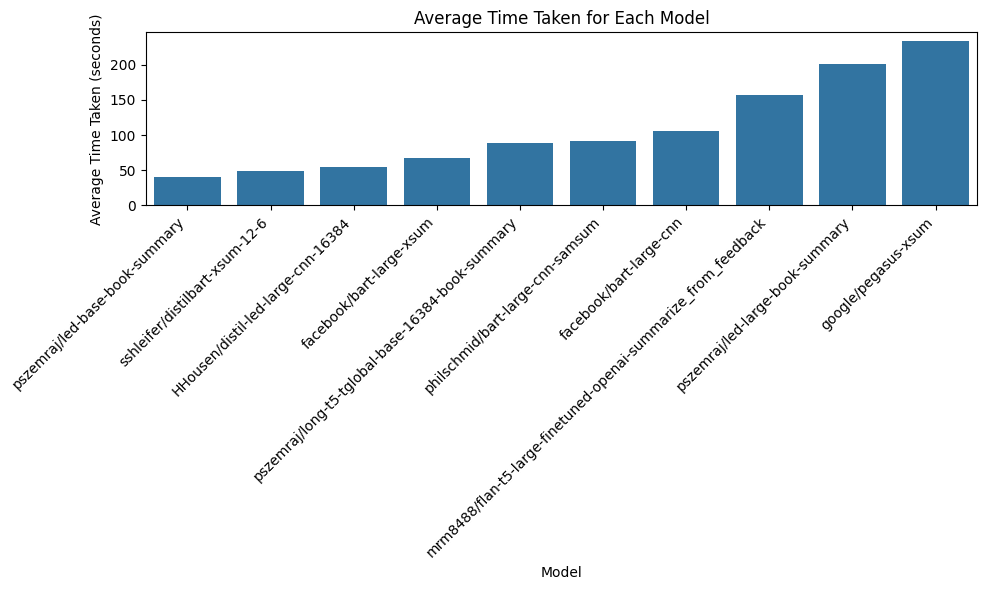

In [18]:
df_avg_time = df_scores.groupby('model')['time_taken'].mean().reset_index()

df_avg_time = df_avg_time.sort_values('time_taken', ascending=True)


plt.figure(figsize=(10, 6))
ax = sns.barplot(x='model', y='time_taken', data=df_avg_time)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.xlabel('Model')
plt.ylabel('Average Time Taken (seconds)')
plt.title('Average Time Taken for Each Model')
plt.tight_layout()
plt.show()

C:\Users\Zhang Xiang\AppData\Local\Temp\ipykernel_27812\198610310.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


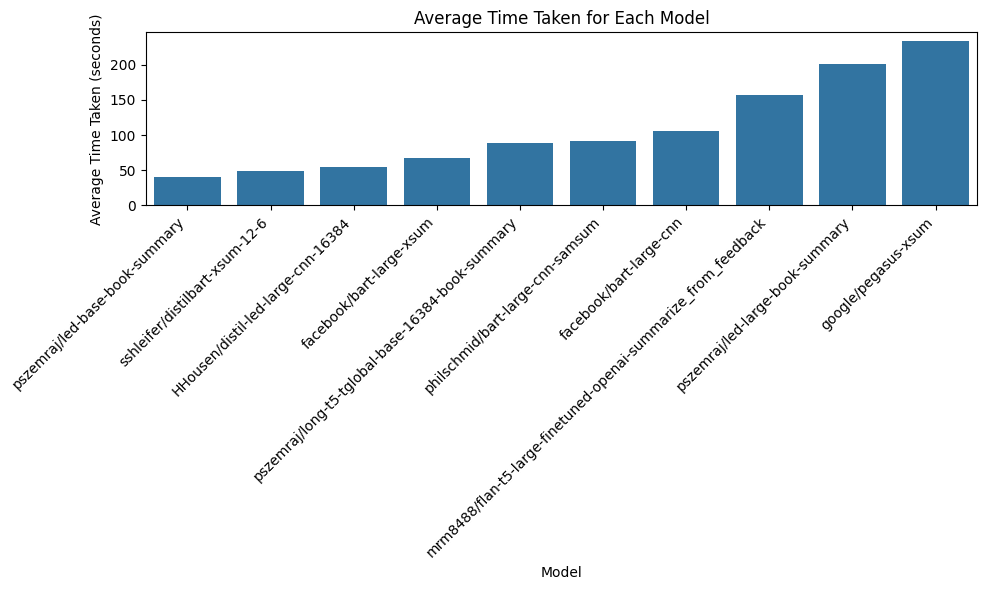

In [19]:
df_avg_time = df_scores.groupby('model')['time_taken'].mean().reset_index()

# Remove model run more than 1000 seconds
df_avg_time = df_avg_time[df_avg_time['time_taken'] <= 1000]
df_avg_time = df_avg_time.sort_values('time_taken', ascending=True)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='model', y='time_taken', data=df_avg_time)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.xlabel('Model')
plt.ylabel('Average Time Taken (seconds)')
plt.title('Average Time Taken for Each Model')
plt.tight_layout()
plt.show()

In [20]:
df_avg_time.reset_index(drop=True)

,model,time_taken
0,pszemraj/led-base-book-summary,40.929855
1,sshleifer/distilbart-xsum-12-6,49.082590
2,HHousen/distil-led-large-cnn-16384,54.395816
3,facebook/bart-large-xsum,67.594652
4,pszemraj/long-t5-tglobal-base-16384-book-summary,88.434769
5,philschmid/bart-large-cnn-samsum,91.274375
6,facebook/bart-large-cnn,105.601601
7,mrm8488/flan-t5-large-finetuned-openai-summari...,156.691596
8,pszemraj/led-large-book-summary,200.992537
9,google/pegasus-xsum,234.581553


##### Filter Top 8 BERT Score Model

In [21]:
import re

def extract_last_f1_score(bert_score_str):
    f1_scores = re.findall(r'tensor\(\[(\d+\.\d+)\]\)', bert_score_str)
    last_f1_score = float(f1_scores[-1])
    return last_f1_score

In [22]:
# Filter removed models
df_scores = df_scores[df_scores['model'].isin(df_avg_time['model'])]

df_scores['last_f1_score'] = df_scores['bert_score'].apply(lambda x: extract_last_f1_score(x))

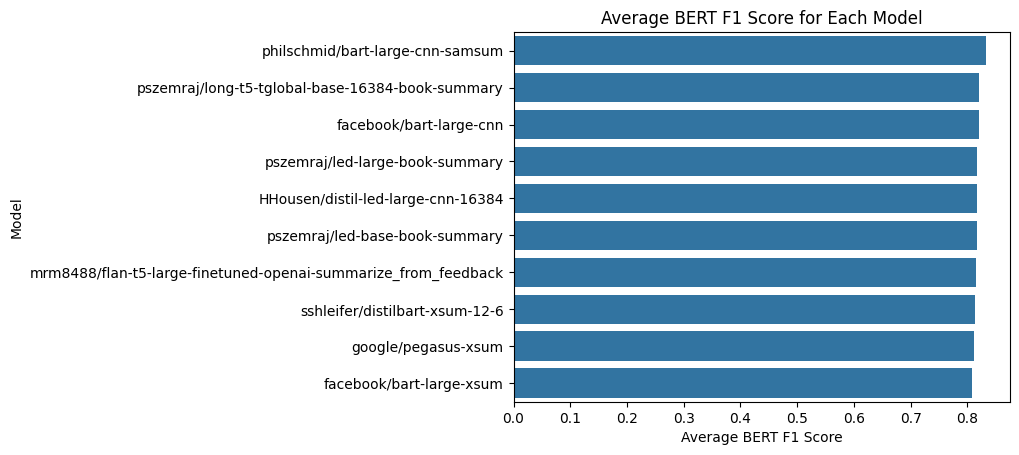

In [23]:
df_avg_last_f1 = df_scores.groupby('model')['last_f1_score'].mean().reset_index()

# Sort the DataFrame by average last F1 score in descending order
df_avg_last_f1 = df_avg_last_f1.sort_values('last_f1_score', ascending=False)

# Create the Seaborn bar plot
sns.barplot(x='last_f1_score', y='model', data=df_avg_last_f1)
plt.xlabel('Average BERT F1 Score')
plt.ylabel('Model')
plt.title('Average BERT F1 Score for Each Model')
plt.show()

In [24]:
df_avg_last_f1 = df_avg_last_f1.head(8)
df_avg_last_f1

,model,last_f1_score
5,philschmid/bart-large-cnn-samsum,0.83260
8,pszemraj/long-t5-tglobal-base-16384-book-summary,0.82086
1,facebook/bart-large-cnn,0.81986
7,pszemraj/led-large-book-summary,0.81770
0,HHousen/distil-led-large-cnn-16384,0.81764
6,pszemraj/led-base-book-summary,0.81698
4,mrm8488/flan-t5-large-finetuned-openai-summari...,0.81452
9,sshleifer/distilbart-xsum-12-6,0.81256


##### Filter top 5 ROUGE F1 Score Model

Filter top 5 models

| ROUGE Score | Strengths | Weaknesses |
|---|---|---|
| ROUGE-1 | Easy to understand, highlights key facts, rewards word matches. | Favors repeated keywords, ignores meaning if words rearranged. |
| ROUGE-2 | Encourages smooth sentences, good grammar. | Similar to ROUGE-1, loves familiar phrases even if unimportant. |
| ROUGE-L | Rewards clever rephrasing, captures deeper meaning. | Picky about word order, might miss key points. |


C:\Users\Zhang Xiang\AppData\Local\Temp\ipykernel_27812\591198911.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
C:\Users\Zhang Xiang\AppData\Local\Temp\ipykernel_27812\591198911.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
C:\Users\Zhang Xiang\AppData\Local\Temp\ipykernel_27812\591198911.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


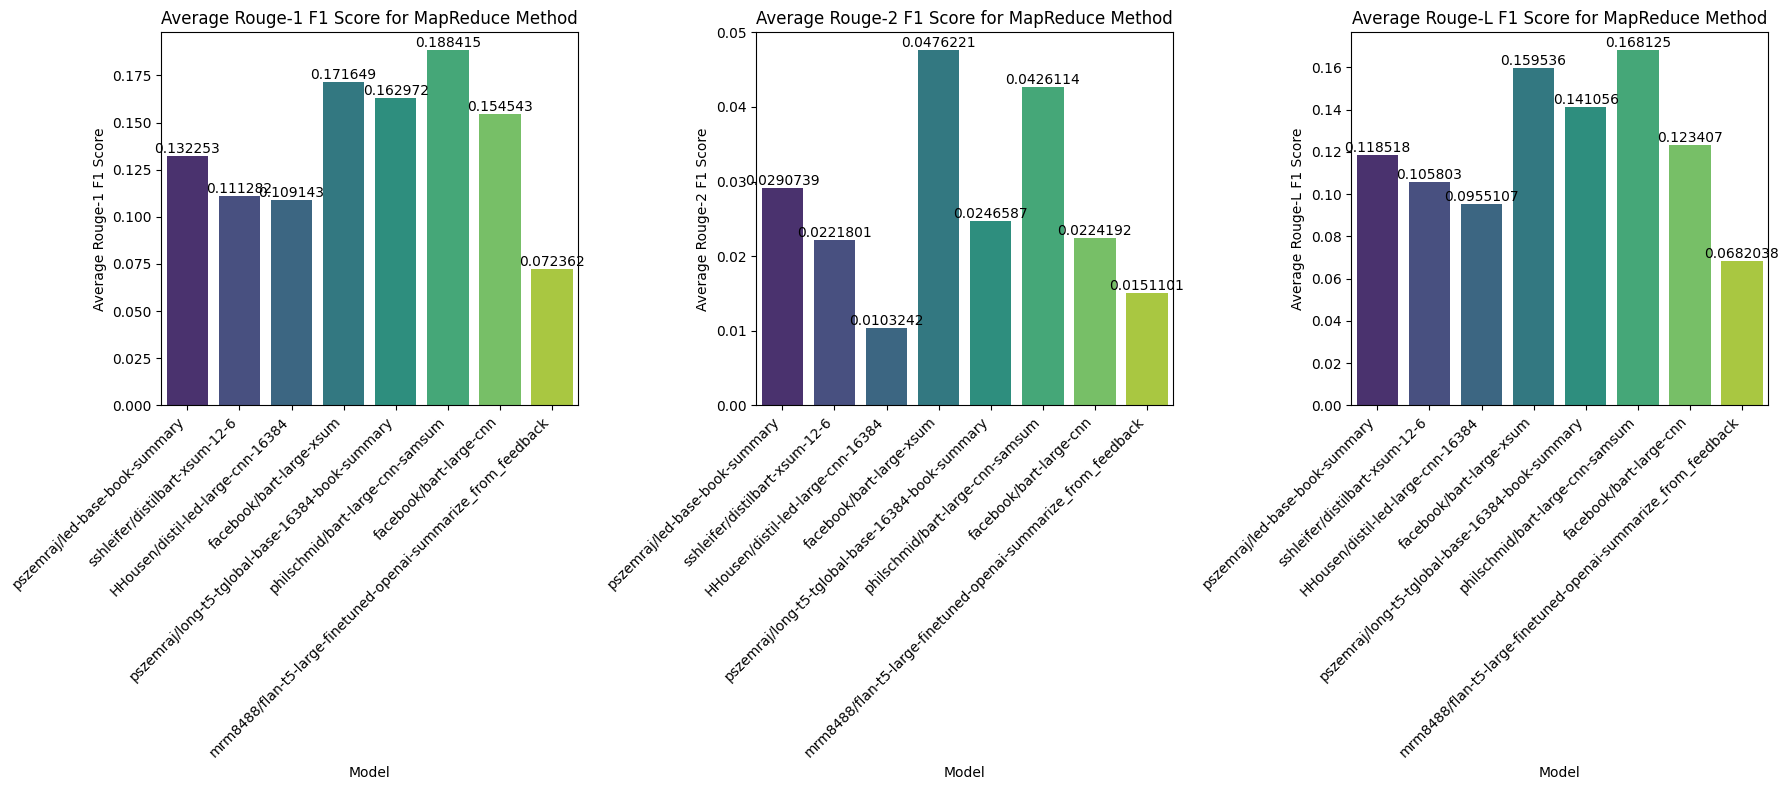

In [25]:
# Filter removed models
df_scores = df_scores[df_scores['model'].isin(df_avg_last_f1['model'])]


# Convert string representation of dict to a dictionary
df_scores['rouge_scores'] = df_scores['rouge'].apply(lambda x: eval(x)[0])

# Extract Rouge-1, Rouge-2, and Rouge-L F1 scores from the dictionary
df_scores['rouge-1_f'] = df_scores['rouge_scores'].apply(lambda x: x['rouge-1']['f'])
df_scores['rouge-2_f'] = df_scores['rouge_scores'].apply(lambda x: x['rouge-2']['f'])
df_scores['rouge-l_f'] = df_scores['rouge_scores'].apply(lambda x: x['rouge-l']['f'])

# Filter data for MapReduce method
df_scores_mapreduce = df_scores[df_scores['method'] == 'MapReduce']

# Calculate the average of Rouge-1, Rouge-2, and Rouge-L F1 scores for each model
avg_rouge1 = df_scores_mapreduce.groupby('model')['rouge-1_f'].mean().reset_index()
avg_rouge2 = df_scores_mapreduce.groupby('model')['rouge-2_f'].mean().reset_index()
avg_rouge_l = df_scores_mapreduce.groupby('model')['rouge-l_f'].mean().reset_index()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 8))

# Plot Charts
sns.barplot(x='model', y='rouge-1_f', data=avg_rouge1, palette='viridis', ax=axes[0], hue='model')
axes[0].set_title('Average Rouge-1 F1 Score for MapReduce Method')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Average Rouge-1 F1 Score')
# axes[0].tick_params(axis='x', labelrotation = 45)
axes[0].set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

for container in axes[0].containers:
    axes[0].bar_label(container)

sns.barplot(x='model', y='rouge-2_f', data=avg_rouge2, palette='viridis', ax=axes[1], hue='model')
axes[1].set_title('Average Rouge-2 F1 Score for MapReduce Method')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Average Rouge-2 F1 Score')
axes[1].set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
for container in axes[1].containers:
    axes[1].bar_label(container)

sns.barplot(x='model', y='rouge-l_f', data=avg_rouge_l, palette='viridis', ax=axes[2], hue='model')
axes[2].set_title('Average Rouge-L F1 Score for MapReduce Method')
axes[2].set_xlabel('Model')
axes[2].set_ylabel('Average Rouge-L F1 Score')
axes[2].set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
for container in axes[2].containers:
    axes[2].bar_label(container)




plt.tight_layout()

plt.show()

In [26]:
avg_rouge1['rouge-1_f'] = pd.to_numeric(avg_rouge1['rouge-1_f'])
avg_rouge2['rouge-2_f'] = pd.to_numeric(avg_rouge2['rouge-2_f'])
avg_rouge_l['rouge-l_f'] = pd.to_numeric(avg_rouge_l['rouge-l_f'])

# Merge the average Rouge scores for each model
avg_rouge = pd.merge(avg_rouge1, avg_rouge2, on='model')
avg_rouge = pd.merge(avg_rouge, avg_rouge_l, on='model')

# Calculate the average Rouge score by taking the mean across Rouge-1, Rouge-2, and Rouge-L scores
avg_rouge['avg_score'] = avg_rouge[['rouge-1_f', 'rouge-2_f', 'rouge-l_f']].mean(axis=1)

# Sort the DataFrame by the average Rouge score in descending order
top_5_models = avg_rouge.sort_values('avg_score', ascending=False).head(5).reset_index(drop=True)

top_5_models["model"]

0                     pszemraj/led-large-book-summary
1                    philschmid/bart-large-cnn-samsum
2                      pszemraj/led-base-book-summary
3    pszemraj/long-t5-tglobal-base-16384-book-summary
4                  HHousen/distil-led-large-cnn-16384
Name: model, dtype: object

#### Top 5 Models Performance

In [6]:
df_scores = pd.read_excel("../Process/result/open_source_model.xlsx")

# top 5 Models
data = {
    'model': [
        'pszemraj/led-base-book-summary',
        'pszemraj/led-large-book-summary',
        'HHousen/distil-led-large-cnn-16384',
        'philschmid/bart-large-cnn-samsum',
        'pszemraj/long-t5-tglobal-base-16384-book-summary'
    ]
}

top_5_models = pd.DataFrame(data)
top_5_models

,model
0,pszemraj/led-base-book-summary
1,pszemraj/led-large-book-summary
2,HHousen/distil-led-large-cnn-16384
3,philschmid/bart-large-cnn-samsum
4,pszemraj/long-t5-tglobal-base-16384-book-summary


In [3]:
# Filter removed models
df_scores = df_scores[df_scores['model'].isin(top_5_models['model'])]


# Convert string representation of dict to a dictionary
df_scores['rouge_scores'] = df_scores['rouge'].apply(lambda x: eval(x)[0])

# Extract Rouge-1, Rouge-2, and Rouge-L F1 scores from the dictionary
df_scores['rouge-1_f'] = df_scores['rouge_scores'].apply(lambda x: x['rouge-1']['f'])
df_scores['rouge-2_f'] = df_scores['rouge_scores'].apply(lambda x: x['rouge-2']['f'])
df_scores['rouge-l_f'] = df_scores['rouge_scores'].apply(lambda x: x['rouge-l']['f'])

# Filter data for MapReduce method
df_scores_mapreduce = df_scores[df_scores['method'] == 'MapReduce']

# Calculate the average of Rouge-1, Rouge-2, and Rouge-L F1 scores for each model
avg_rouge1 = df_scores_mapreduce.groupby('model')['rouge-1_f'].mean().reset_index()
avg_rouge2 = df_scores_mapreduce.groupby('model')['rouge-2_f'].mean().reset_index()
avg_rouge_l = df_scores_mapreduce.groupby('model')['rouge-l_f'].mean().reset_index()

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 8))

# Plot Charts
sns.barplot(x='model', y='rouge-1_f', data=avg_rouge1, palette='viridis', ax=axes[0], hue='model')
axes[0].set_title('Average Rouge-1 F1 Score for MapReduce Method')
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Average Rouge-1 F1 Score')
# axes[0].tick_params(axis='x', labelrotation = 45)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

for container in axes[0].containers:
    axes[0].bar_label(container)

sns.barplot(x='model', y='rouge-2_f', data=avg_rouge2, palette='viridis', ax=axes[1], hue='model')
axes[1].set_title('Average Rouge-2 F1 Score for MapReduce Method')
axes[1].set_xlabel('Model')
axes[1].set_ylabel('Average Rouge-2 F1 Score')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
for container in axes[1].containers:
    axes[1].bar_label(container)

sns.barplot(x='model', y='rouge-l_f', data=avg_rouge_l, palette='viridis', ax=axes[2], hue='model')
axes[2].set_title('Average Rouge-L F1 Score for MapReduce Method')
axes[2].set_xlabel('Model')
axes[2].set_ylabel('Average Rouge-L F1 Score')
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')
for container in axes[2].containers:
    axes[2].bar_label(container)




plt.tight_layout()

plt.show()

NameError: name 'df_scores' is not defined

In [4]:
filtered_df = df_scores[["model", "max_tokens"]]
filtered_df = filtered_df[filtered_df["model"].isin(top_5_models["model"])]

top_5_models = filtered_df.drop_duplicates()

top_5_models

NameError: name 'df_scores' is not defined

In [ ]:

# top 5 Models
data = {
    'model': [
        'pszemraj/led-base-book-summary',
        'pszemraj/led-large-book-summary',
        'HHousen/distil-led-large-cnn-16384',
        'philschmid/bart-large-cnn-samsum',
        'pszemraj/long-t5-tglobal-base-16384-book-summary'
    ]
}

top_5_models = pd.DataFrame(data)
top_5_models

### Text Ranking Method

In [31]:
df_scores = pd.DataFrame(columns=['model', 'method', 'max_tokens' ,'transcript','original summary', 'summary', 'rouge','bert_score', 'bleu', 'time_taken', 'grammar', 'readability', 'sent_count'])

In [14]:
sent_count_list = [10, 50, 100]

In [34]:
from sumy.summarizers.lsa import LsaSummarizer
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer



for sent_count in sent_count_list:

    for model_name in top_5_models['model']:
        print(model_name)
        tokenizer = AutoTokenizer.from_pretrained(model_name)
        model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

        for index, row in df_test.iterrows():
            method = "TextRank"
            
            # get the summary
            start_time = time.time()
            
            parser = PlaintextParser.from_string(row["transcript"], Tokenizer("english"))


            summarizer_lsa = LsaSummarizer()
            summary =summarizer_lsa(parser.document, sent_count)

            lsa_summary=""
            for sentence in summary:
                lsa_summary+=str(sentence)


            max_tokens = tokenizer.model_max_length
            summary_chain = summ_pipeline(model, tokenizer, "map_reduce", max_tokens)

            # Used for efficient tokenization and processing of long texts when working with language models
            text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=max_tokens-100, chunk_overlap=100)
            docs = text_splitter.create_documents([lsa_summary])
            summary = summary_chain.run(docs)


            end_time = time.time()
            elapsed_time = end_time - start_time
            
            metrics = SummarizationMetrics(row['summary'], summary)

            new_result = {
                'model': model_name,
                'method': method,
                'max_tokens': max_tokens,
                'transcript': row['transcript'],
                'original summary': row['summary'],
                'summary': summary,
                'rouge': metrics.rouge_scores(),
                'bert_score': metrics.bert_score(),
                'bleu': metrics.bleu_score(),
                'time_taken': elapsed_time,
                'grammar': metrics.grammar_check(),
                'readability': metrics.readability_index(),
                'sent_count': sent_count
            }


            new_row = pd.DataFrame([new_result])

            df_scores = pd.concat([df_scores, new_row], ignore_index=True)


HHousen/distil-led-large-cnn-16384


Your max_length is set to 16384, but your input_length is only 292. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=146)
Your max_length is set to 16384, but your input_length is only 80. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.54s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 249.94it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 2.55 seconds, 0.39 sentences/sec


C:\Users\Zhang Xiang\AppData\Local\Temp\ipykernel_19748\2074459503.py:64: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_scores = pd.concat([df_scores, new_row], ignore_index=True)
Your max_length is set to 16384, but your input_length is only 264. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=132)
Your max_length is set to 16384, but your input_length is only 96. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)
Some weights of RobertaModel were not initialized from the mode

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.39s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 199.90it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 2.40 seconds, 0.42 sentences/sec


Your max_length is set to 16384, but your input_length is only 272. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=136)
Your max_length is set to 16384, but your input_length is only 81. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.85s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 333.25it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 2.86 seconds, 0.35 sentences/sec


Your max_length is set to 16384, but your input_length is only 347. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=173)
Your max_length is set to 16384, but your input_length is only 79. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.98s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 298.65it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 2.99 seconds, 0.33 sentences/sec


Your max_length is set to 16384, but your input_length is only 274. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=137)
Your max_length is set to 16384, but your input_length is only 96. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=48)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.29s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 332.54it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 2.30 seconds, 0.44 sentences/sec
philschmid/bart-large-cnn-samsum


Your max_length is set to 1024, but your input_length is only 292. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=146)
Your max_length is set to 1024, but your input_length is only 93. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.42s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 83.34it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 2.45 seconds, 0.41 sentences/sec


Your max_length is set to 1024, but your input_length is only 264. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=132)
Your max_length is set to 1024, but your input_length is only 74. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=37)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:05<00:00,  5.16s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 25.63it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 5.26 seconds, 0.19 sentences/sec


Your max_length is set to 1024, but your input_length is only 272. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=136)
Your max_length is set to 1024, but your input_length is only 84. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.91s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 49.00it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 2.95 seconds, 0.34 sentences/sec


Your max_length is set to 1024, but your input_length is only 347. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=173)
Your max_length is set to 1024, but your input_length is only 85. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=42)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:03<00:00,  3.71s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 249.97it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 3.72 seconds, 0.27 sentences/sec


Your max_length is set to 1024, but your input_length is only 274. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=137)
Your max_length is set to 1024, but your input_length is only 86. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=43)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.99s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 499.38it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 2.00 seconds, 0.50 sentences/sec
pszemraj/long-t5-tglobal-base-16384-book-summary


Your max_length is set to 1000000000000000019884624838656, but your input_length is only 317. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=158)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\transformers\modeling_utils.py:896: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
Your max_length is set to 1000000000000000019884624838656, but your input_length is only 125. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\transformers\modeling_utils.py:896: FutureWarning: The `de

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:03<00:00,  3.50s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 111.09it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 3.52 seconds, 0.28 sentences/sec


Your max_length is set to 1000000000000000019884624838656, but your input_length is only 278. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=139)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\transformers\modeling_utils.py:896: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
Your max_length is set to 1000000000000000019884624838656, but your input_length is only 64. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=32)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\transformers\modeling_utils.py:896: FutureWarning: The `dev

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.84s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 360.49it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 1.85 seconds, 0.54 sentences/sec


Your max_length is set to 1000000000000000019884624838656, but your input_length is only 290. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=145)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\transformers\modeling_utils.py:896: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
Your max_length is set to 1000000000000000019884624838656, but your input_length is only 127. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=63)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\transformers\modeling_utils.py:896: FutureWarning: The `de

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:03<00:00,  3.32s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 249.99it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 3.33 seconds, 0.30 sentences/sec


Your max_length is set to 1000000000000000019884624838656, but your input_length is only 381. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=190)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\transformers\modeling_utils.py:896: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
Your max_length is set to 1000000000000000019884624838656, but your input_length is only 91. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\transformers\modeling_utils.py:896: FutureWarning: The `dev

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:03<00:00,  3.24s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 281.88it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 3.25 seconds, 0.31 sentences/sec


Your max_length is set to 1000000000000000019884624838656, but your input_length is only 300. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=150)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\transformers\modeling_utils.py:896: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
Your max_length is set to 1000000000000000019884624838656, but your input_length is only 78. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=39)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\transformers\modeling_utils.py:896: FutureWarning: The `dev

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.93s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 333.28it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 1.94 seconds, 0.52 sentences/sec
pszemraj/led-large-book-summary


Your max_length is set to 16384, but your input_length is only 292. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=146)
Your max_length is set to 16384, but your input_length is only 216. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=108)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:04<00:00,  4.12s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 31.91it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 4.17 seconds, 0.24 sentences/sec


Your max_length is set to 16384, but your input_length is only 264. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=132)
Your max_length is set to 16384, but your input_length is only 113. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=56)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.71s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 300.99it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 1.72 seconds, 0.58 sentences/sec


Your max_length is set to 16384, but your input_length is only 272. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=136)
Your max_length is set to 16384, but your input_length is only 81. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=40)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:03<00:00,  3.52s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 166.64it/s]


done in 3.53 seconds, 0.28 sentences/sec


Your max_length is set to 16384, but your input_length is only 347. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=173)
Your max_length is set to 16384, but your input_length is only 90. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=45)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:05<00:00,  5.54s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 249.94it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 5.56 seconds, 0.18 sentences/sec


Your max_length is set to 16384, but your input_length is only 274. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=137)
Your max_length is set to 16384, but your input_length is only 130. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=65)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 319.59it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 2.06 seconds, 0.49 sentences/sec
pszemraj/led-base-book-summary


Your max_length is set to 16384, but your input_length is only 292. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=146)
Your max_length is set to 16384, but your input_length is only 270. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=135)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.24s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 200.13it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\t

done in 2.25 seconds, 0.44 sentences/sec


Your max_length is set to 16384, but your input_length is only 264. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=132)
Your max_length is set to 16384, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 250.02it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 1.88 seconds, 0.53 sentences/sec


Your max_length is set to 16384, but your input_length is only 272. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=136)
Your max_length is set to 16384, but your input_length is only 68. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=34)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.70s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 45.44it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 2.73 seconds, 0.37 sentences/sec


Your max_length is set to 16384, but your input_length is only 347. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=173)
Your max_length is set to 16384, but your input_length is only 36. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=18)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:03<00:00,  3.94s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 50.56it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 3.98 seconds, 0.25 sentences/sec


Your max_length is set to 16384, but your input_length is only 274. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=137)
Your max_length is set to 16384, but your input_length is only 109. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=54)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 249.78it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 2.06 seconds, 0.49 sentences/sec
HHousen/distil-led-large-cnn-16384


Your max_length is set to 16384, but your input_length is only 1515. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=757)
Your max_length is set to 16384, but your input_length is only 89. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.27s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 142.88it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 2.29 seconds, 0.44 sentences/sec


Your max_length is set to 16384, but your input_length is only 1436. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=718)
Your max_length is set to 16384, but your input_length is only 88. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=44)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.64s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 500.04it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 1.65 seconds, 0.61 sentences/sec


Your max_length is set to 16384, but your input_length is only 1609. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=804)
Your max_length is set to 16384, but your input_length is only 98. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.95s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 333.41it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 2.96 seconds, 0.34 sentences/sec


Your max_length is set to 16384, but your input_length is only 1638. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=819)
Your max_length is set to 16384, but your input_length is only 92. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=46)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:03<00:00,  3.23s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 142.89it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 3.25 seconds, 0.31 sentences/sec


Your max_length is set to 16384, but your input_length is only 1348. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=674)
Your max_length is set to 16384, but your input_length is only 98. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=49)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.90s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 249.82it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 1.91 seconds, 0.52 sentences/sec
philschmid/bart-large-cnn-samsum


Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 691. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=345)
Your max_length is set to 1024, but your input_length is only 151. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=75)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.72s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 45.45it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 2.78 seconds, 0.36 sentences/sec


Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 612. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=306)
Your max_length is set to 1024, but your input_length is only 140. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=70)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 71.33it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 1.91 seconds, 0.52 sentences/sec


Your max_length is set to 1024, but your input_length is only 942. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=471)
Your max_length is set to 1024, but your input_length is only 790. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=395)
Your max_length is set to 1024, but your input_length is only 184. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=92)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:02<00:00,  2.97s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 332.96it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 2.98 seconds, 0.34 sentences/sec


Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 814. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=407)
Your max_length is set to 1024, but your input_length is only 138. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=69)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be

calculating scores...
computing bert embedding.


100%|██████████| 1/1 [00:03<00:00,  3.28s/it]


computing greedy matching.


100%|██████████| 1/1 [00:00<00:00, 76.93it/s]
c:\Users\Zhang Xiang\Desktop\Year 3\Sem 2\FYPJ\Project\RD_TextSummarizerForWebinar\Development\.venv\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


done in 3.31 seconds, 0.30 sentences/sec


Your max_length is set to 1024, but your input_length is only 947. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=473)
Your max_length is set to 1024, but your input_length is only 524. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=262)
Your max_length is set to 1024, but your input_length is only 138. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=69)


: 

In [ ]:
df_scores

,model,method,max_tokens,transcript,original summary,summary,rouge,bert_score,bleu,time_taken,grammar,readability,sent_count
0,HHousen/distil-led-large-cnn-16384,TextRank,16384,All right. So our next talk is called Hacking...,A firsthand look at efforts to improve diversi...,Douglas argues that this started with ham rad...,"[{'rouge-1': {'r': 0.05357142857142857, 'p': 0...","([tensor(0.8072)], [tensor(0.7960)], [tensor(0...",2.721885e-156,16.936625,"[Offset 74, length 2, Rule ID: COMMA_PARENTHES...",100 words required.,10
1,HHousen/distil-led-large-cnn-16384,TextRank,16384,"Welcome, DEF CON 28, the Do No Harm panel. Th...",It is certainly a time of discovery- though th...,"The number of devices out there every year, i...","[{'rouge-1': {'r': 0.11811023622047244, 'p': 0...","([tensor(0.8280)], [tensor(0.8035)], [tensor(0...",1.602289e-79,18.773151,"[Offset 76, length 2, Rule ID: COMMA_PARENTHES...",100 words required.,10
2,HHousen/distil-led-large-cnn-16384,TextRank,16384,Good morning. As you can see from the title o...,Roman Architecture (HSAR 252) Professor Kleine...,The Mosaic Atrium is not a huge basilica . Th...,"[{'rouge-1': {'r': 0.05714285714285714, 'p': 0...","([tensor(0.7958)], [tensor(0.7664)], [tensor(0...",2.744113e-157,22.880661,"[Offset 41, length 2, Rule ID: COMMA_PARENTHES...",100 words required.,10
3,philschmid/bart-large-cnn-samsum,TextRank,1024,All right. So our next talk is called Hacking...,A firsthand look at efforts to improve diversi...,There are more and more explicitly dedicated f...,"[{'rouge-1': {'r': 0.07142857142857142, 'p': 0...","([tensor(0.8549)], [tensor(0.8110)], [tensor(0...",3.079673e-80,20.936985,[],100 words required.,10
4,philschmid/bart-large-cnn-samsum,TextRank,1024,"Welcome, DEF CON 28, the Do No Harm panel. Th...",It is certainly a time of discovery- though th...,Quadim is grateful to have an amazing panel th...,"[{'rouge-1': {'r': 0.10236220472440945, 'p': 0...","([tensor(0.8438)], [tensor(0.8059)], [tensor(0...",8.724663e-80,14.089572,"[Offset 0, length 6, Rule ID: MORFOLOGIK_RULE_...",100 words required.,10
5,philschmid/bart-large-cnn-samsum,TextRank,1024,Good morning. As you can see from the title o...,Roman Architecture (HSAR 252) Professor Kleine...,There was an earthquake in Pompeii. People fle...,"[{'rouge-1': {'r': 0.06428571428571428, 'p': 0...","([tensor(0.8467)], [tensor(0.7775)], [tensor(0...",3.861566e-157,13.185700,[],100 words required.,10
6,pszemraj/long-t5-tglobal-base-16384-book-summary,TextRank,1000000000000000019884624838656,All right. So our next talk is called Hacking...,A firsthand look at efforts to improve diversi...,Douglas explains the concept of hacker spaces ...,"[{'rouge-1': {'r': 0.05357142857142857, 'p': 0...","([tensor(0.8467)], [tensor(0.7997)], [tensor(0...",6.915383e-158,9.347170,[],100 words required.,10
7,pszemraj/long-t5-tglobal-base-16384-book-summary,TextRank,1000000000000000019884624838656,"Welcome, DEF CON 28, the Do No Harm panel. Th...",It is certainly a time of discovery- though th...,This paper summarizes some of the House's acti...,"[{'rouge-1': {'r': 0.07874015748031496, 'p': 0...","([tensor(0.8388)], [tensor(0.8006)], [tensor(0...",3.631396e-156,6.987517,"[Offset 91, length 6, Rule ID: MORFOLOGIK_RULE...",100 words required.,10
8,pszemraj/long-t5-tglobal-base-16384-book-summary,TextRank,1000000000000000019884624838656,Good morning. As you can see from the title o...,Roman Architecture (HSAR 252) Professor Kleine...,The next scene opens in the courtyard where a ...,"[{'rouge-1': {'r': 0.07142857142857142, 'p': 0...","([tensor(0.8474)], [tensor(0.7718)], [tensor(0...",2.161220e-157,6.415866,[],100 words required.,10
9,pszemraj/led-large-book-summary,TextRank,16384,All right. So our next talk is called Hacking...,A firsthand look at efforts to improve diversi...,Consequence asks the audience to write a summa...,"[{'rouge-1': {'r': 0.05357142857142857, 'p': 0...","([tensor(0.8333)], [tensor(0.8017)], [tensor(0...",1.198007e-156,29.077253

In [ ]:
# df_scores.to_excel("./result/open_source_model_rank.xlsx")

In [11]:
df_scores = pd.read_excel("./result/open_source_model_rank.xlsx")

In [12]:
df_scores['rouge'][0][0]

'['

sent_count: 10


C:\Users\Zhang Xiang\AppData\Local\Temp\ipykernel_27812\2072211868.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
C:\Users\Zhang Xiang\AppData\Local\Temp\ipykernel_27812\2072211868.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
C:\Users\Zhang Xiang\AppData\Local\Temp\ipykernel_27812\2072211868.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')


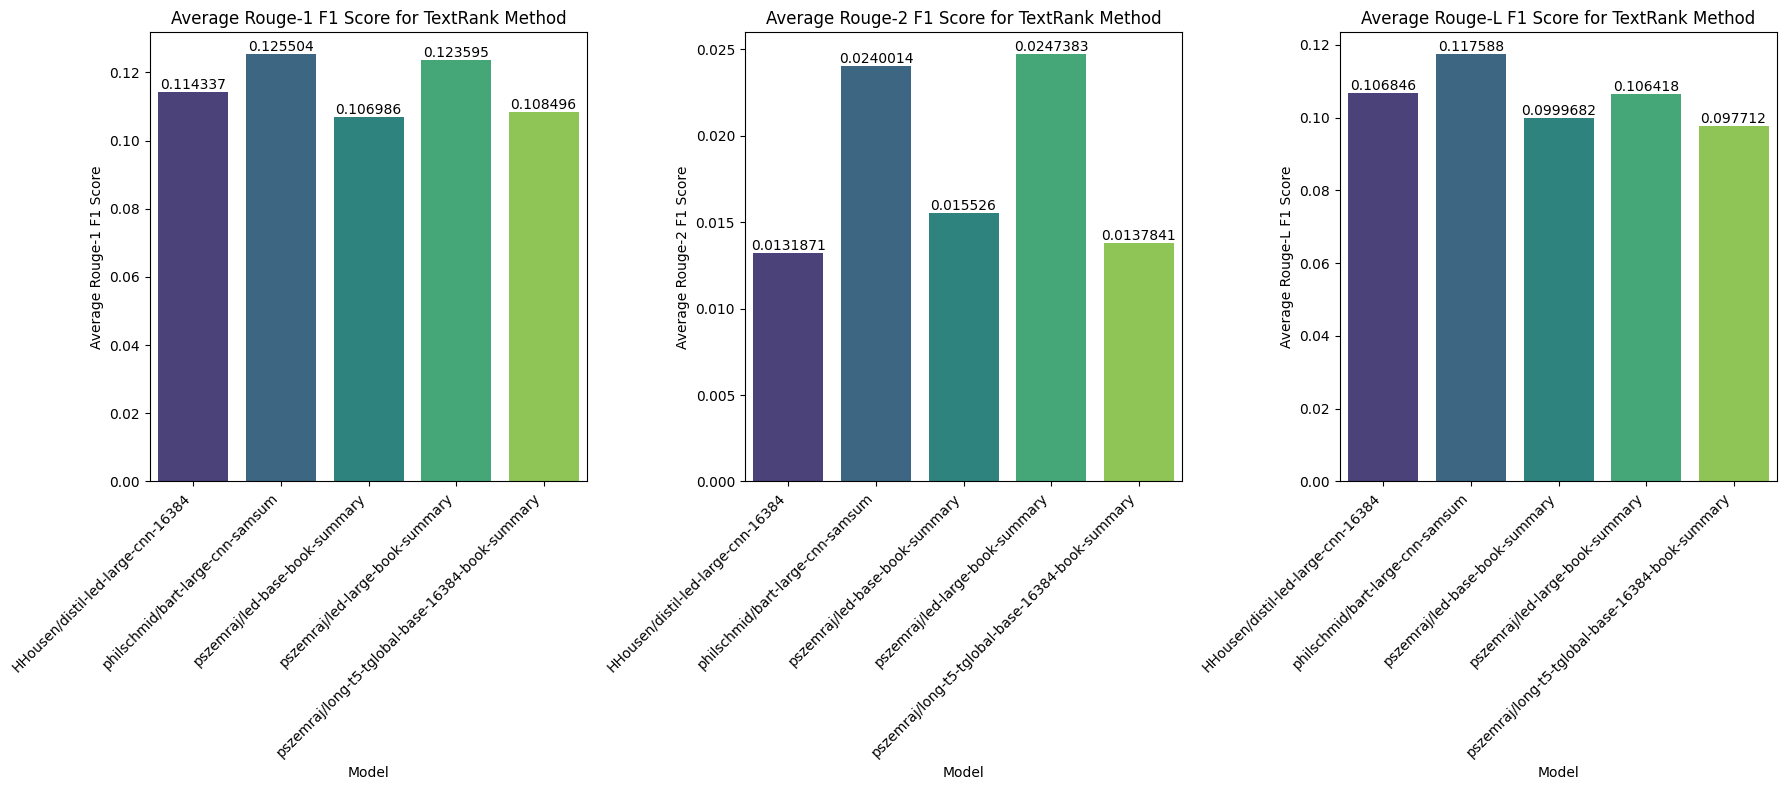

sent_count: 50


C:\Users\Zhang Xiang\AppData\Local\Temp\ipykernel_27812\2072211868.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
C:\Users\Zhang Xiang\AppData\Local\Temp\ipykernel_27812\2072211868.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
C:\Users\Zhang Xiang\AppData\Local\Temp\ipykernel_27812\2072211868.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')


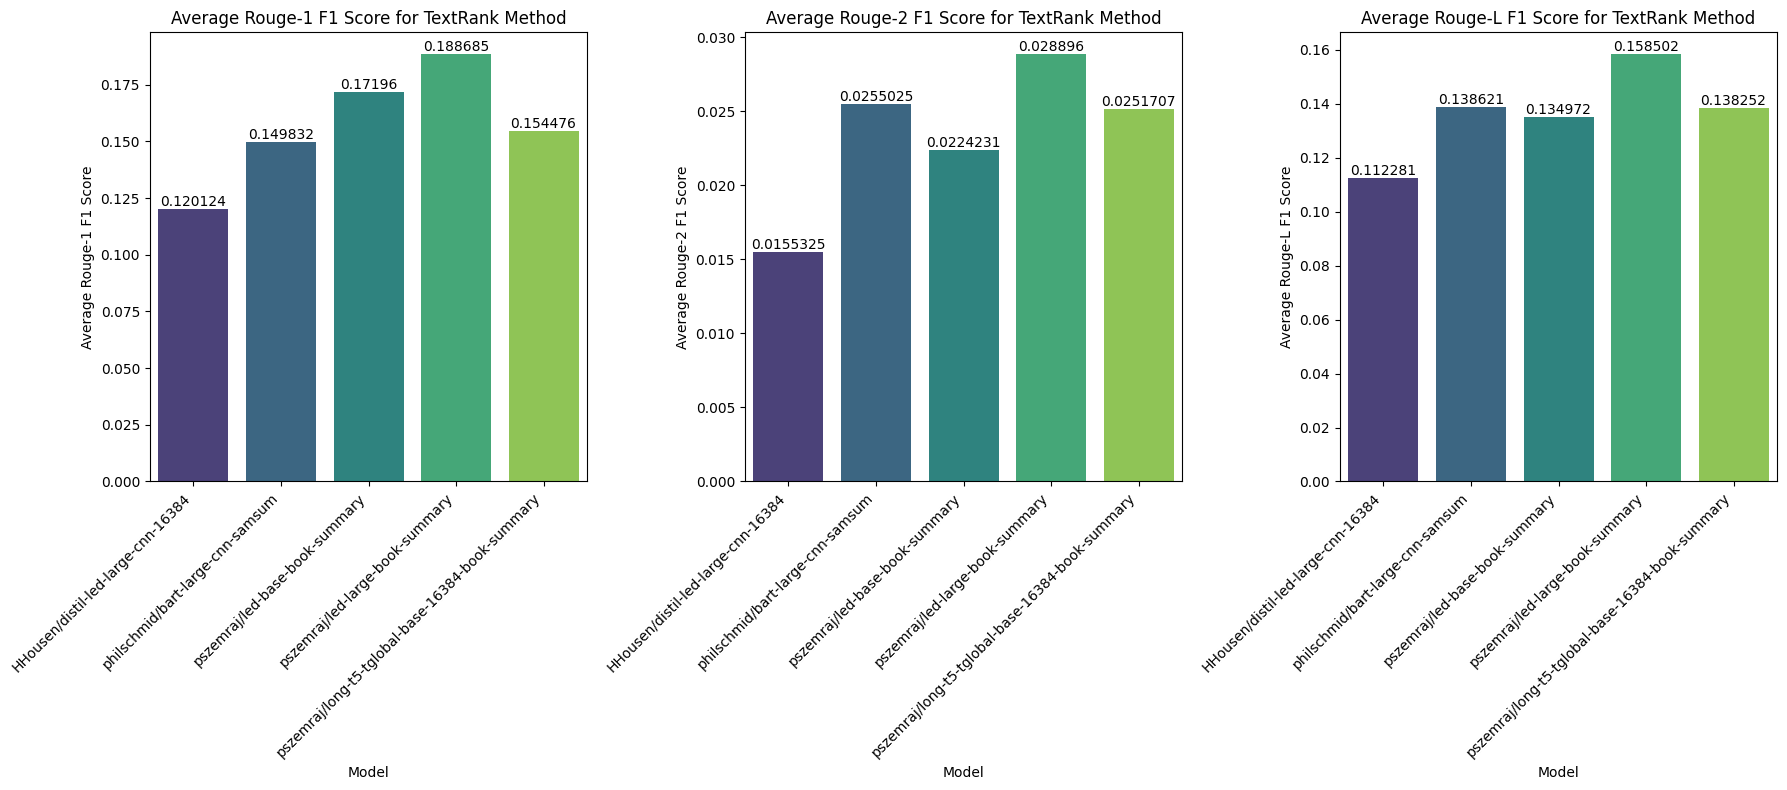

sent_count: 100


C:\Users\Zhang Xiang\AppData\Local\Temp\ipykernel_27812\2072211868.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
C:\Users\Zhang Xiang\AppData\Local\Temp\ipykernel_27812\2072211868.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
C:\Users\Zhang Xiang\AppData\Local\Temp\ipykernel_27812\2072211868.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')


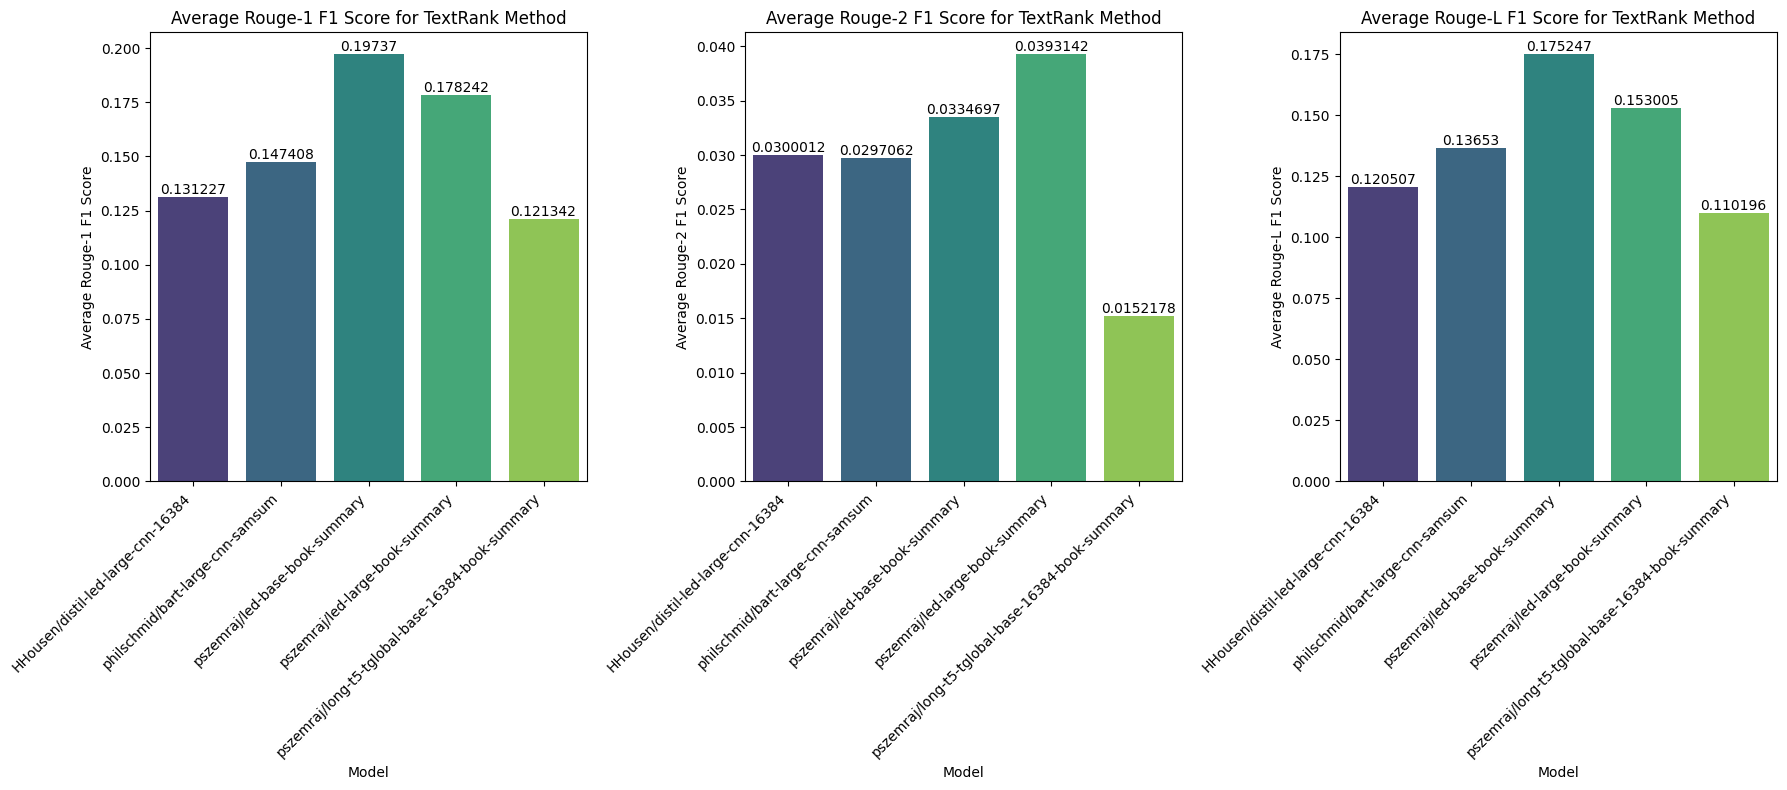

In [16]:
# # Filter removed models
# df_scores = df_scores[df_scores['model'].isin(df_avg_last_f1['model'])]

# Convert string representation of dict to a dictionary
df_scores['rouge_scores'] = df_scores['rouge'].apply(lambda x: eval(x)[0])

# Extract Rouge-1, Rouge-2, and Rouge-L F1 scores from the dictionary
df_scores['rouge-1_f'] = df_scores['rouge_scores'].apply(lambda x: x['rouge-1']['f'])
df_scores['rouge-2_f'] = df_scores['rouge_scores'].apply(lambda x: x['rouge-2']['f'])
df_scores['rouge-l_f'] = df_scores['rouge_scores'].apply(lambda x: x['rouge-l']['f'])

for sent_count in sent_count_list:
    print("sent_count:", sent_count)
    # Filter data for MapReduce method
    df_scores_textrank = df_scores[(df_scores['method'] == 'TextRank') & (df_scores['sent_count'] == sent_count)]

    # Calculate the average of Rouge-1, Rouge-2, and Rouge-L F1 scores for each model
    avg_rouge1 = df_scores_textrank.groupby('model')['rouge-1_f'].mean().reset_index()
    avg_rouge2 = df_scores_textrank.groupby('model')['rouge-2_f'].mean().reset_index()
    avg_rouge_l = df_scores_textrank.groupby('model')['rouge-l_f'].mean().reset_index()

    # Gather all data into a single DataFrame
    # avg_scores = pd.concat([avg_rouge1[['model', 'rouge-1_f']], avg_rouge2[['model', 'rouge-2_f']], avg_rouge_l[['model', 'rouge-l_f']]], axis=1)


    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 8))

    # Plot Charts
    sns.barplot(x='model', y='rouge-1_f', data=avg_rouge1, palette='viridis', ax=axes[0], hue='model')
    axes[0].set_title('Average Rouge-1 F1 Score for TextRank Method')
    axes[0].set_xlabel('Model')
    axes[0].set_ylabel('Average Rouge-1 F1 Score')
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
    for container in axes[0].containers:
        axes[0].bar_label(container)


    sns.barplot(x='model', y='rouge-2_f', data=avg_rouge2, palette='viridis', ax=axes[1], hue='model')
    axes[1].set_title('Average Rouge-2 F1 Score for TextRank Method')
    axes[1].set_xlabel('Model')
    axes[1].set_ylabel('Average Rouge-2 F1 Score')
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
    for container in axes[1].containers:
        axes[1].bar_label(container)

    sns.barplot(x='model', y='rouge-l_f', data=avg_rouge_l, palette='viridis', ax=axes[2], hue='model')
    axes[2].set_title('Average Rouge-L F1 Score for TextRank Method')
    axes[2].set_xlabel('Model')
    axes[2].set_ylabel('Average Rouge-L F1 Score')
    axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha='right')
    for container in axes[2].containers:
        axes[2].bar_label(container)




    plt.tight_layout()

    plt.show()
